# **Modeling with a Neural Network**

## Part 1: Data Preparation

In [1]:
## Function for determining Precision Score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def getAvgPrecision(top_classes, test_labels, predictions):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(top_classes)):
        precision[i], recall[i], _ = precision_recall_curve(test_labels[:, i],
                                                        predictions[:, i])
        average_precision[i] = average_precision_score(test_labels[:, i], predictions[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(test_labels.ravel(),
        predictions.ravel())
    average_precision["micro"] = average_precision_score(test_labels, predictions,
                                                     average="micro")
    return average_precision

In [2]:
## Function for determining ROC AUC

from sklearn.metrics import roc_auc_score

def getAvgAUC(test_labels, predictions):
    weighted_roc_auc_ovr = roc_auc_score(test_labels, predictions, multi_class="ovr",
                                     average="macro")
    return weighted_roc_auc_ovr

In [3]:
## Function for determining Recall Score

from sklearn.metrics import recall_score

def getAvgRecall(test_labels, predictions):
    avg_recall = recall_score(test_labels, predictions, average='micro')
    
    return avg_recall

In [4]:
import tensorflow as tf
from tensorflow import keras

In [5]:
import pandas as pd
import numpy as np
import os

In [6]:
data=pd.read_csv('Crime_Clean2.csv')

In [7]:
len(data)

235368

In [8]:
data = data[data['Crime Name1'] != 'Other']
data = data[~(data['Crime Name1'].isnull())]

In [9]:
data['Crime Name1'].value_counts()

Crime Against Property    103669
Crime Against Society      59437
Crime Against Person       21904
Not a Crime                 2817
Name: Crime Name1, dtype: int64

In [10]:
data=data[data['Crime Name1'] != 'Not a Crime']

In [11]:
data['Crime Name1'].value_counts()

Crime Against Property    103669
Crime Against Society      59437
Crime Against Person       21904
Name: Crime Name1, dtype: int64

In [12]:
data['Place'].value_counts()

Street - In vehicle            27246
Residence - Single Family      13871
Street - Residential           13804
Residence - Apartment/Condo    13445
Other/Unknown                  11900
                               ...  
Pawn Shop                         42
Retail - Video Store              30
Nursery                           15
Lake/Waterway                     13
Pedestrian Tunnel                  9
Name: Place, Length: 83, dtype: int64

In [13]:
data['Police District Name'].value_counts()

SILVER SPRING          41449
WHEATON                36321
MONTGOMERY VILLAGE     31156
BETHESDA               24816
GERMANTOWN             23930
ROCKVILLE              23283
CITY OF TAKOMA PARK     4051
TAKOMA PARK                3
OTHER                      1
Name: Police District Name, dtype: int64

In [14]:
data = data[data['Police District Name'] != 'OTHER']
data = data[data['Police District Name'] != 'TAKOMA PARK']
data['Police District Name'].value_counts()

SILVER SPRING          41449
WHEATON                36321
MONTGOMERY VILLAGE     31156
BETHESDA               24816
GERMANTOWN             23930
ROCKVILLE              23283
CITY OF TAKOMA PARK     4051
Name: Police District Name, dtype: int64

In [15]:
classes = data['Crime Name1'].value_counts()

top_classes = list(classes.index.values)

top_classes = sorted(top_classes)
top_classes

['Crime Against Person', 'Crime Against Property', 'Crime Against Society']

In [16]:
len(data)

185006

In [17]:
## Label Encode the target variable 
data['Target'] = data['Crime Name1'].astype('category').cat.codes

In [18]:
## Create a column that gives the number of words for each place corresponding to each crime
data['Num_Words_Place'] = data['Place'].apply(lambda x: len(x.split()))

In [19]:
## Create variable that categorizes or bins the number of words for each place and each crime
data['Bins1'] = pd.cut(data['Num_Words_Place'], bins=[0,5,10,15,20], labels=['0-5','5-10','10-15','15-20'])

In [20]:
## Group the data by bin counts
Word_Dist1 = data.groupby('Bins1').size().reset_index().rename(columns={0:'Counts'})

In [21]:
Word_Dist1.head()

,Bins1,Counts
0,0-5,184376
1,5-10,630
2,10-15,0
3,15-20,0


In [22]:
num_class = len(np.unique(data['Target'].values))
y = data['Target'].values

In [23]:
num_class

3

In [24]:
y

array([0, 1, 1, ..., 2, 2, 1], dtype=int8)

In [25]:
# Fit a tokenizer to the Place variable to tokenize the Place variable such that a word embedding space can be 
# constructed from it

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len=10
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Place'].values)
post_seq = tokenizer.texts_to_sequences(data['Place'].values)
post_seq_padded = pad_sequences(post_seq,maxlen=max_len)

In [26]:
post_seq_padded[0]

array([ 0,  0,  0,  0,  0,  0,  0,  2, 11, 12], dtype=int32)

In [27]:
post_seq_padded[2]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  7, 15], dtype=int32)

In [28]:
post_seq_padded.shape

(185006, 10)

In [29]:
## One-hot encode Police District Variable

data = pd.get_dummies(data, prefix = ['Police District Name'], columns = ['Police District Name'])

In [30]:
## Create set of numerical/quantiative features for model

features = data[['Income','Pop','Public Transportation %','High School %', 'Bachelors %', 'Age', 'Unemployed %', 'Victims','Black %', 'White %',
                'Police District Name_BETHESDA', 'Police District Name_CITY OF TAKOMA PARK', 'Police District Name_GERMANTOWN',
                'Police District Name_ROCKVILLE', 'Police District Name_MONTGOMERY VILLAGE', 'Police District Name_SILVER SPRING',
                'Police District Name_WHEATON']]

In [31]:
features = np.array(features)

In [32]:
features[0]

array([1.56250000e+05, 1.92200000e+03, 4.95145631e-02, 8.37138508e-02,
       2.70167428e-01, 4.66000000e+01, 2.90534208e-02, 1.00000000e+00,
       1.01098901e-01, 8.03846154e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [33]:
features.shape

(185006, 17)

In [34]:
## Fit all numerical data to a uniform scale

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

features = scaler.fit_transform(features)

In [35]:
features[0]

array([0.59120857, 0.17772346, 0.07857241, 0.16107789, 0.50371712,
       0.35332253, 0.09163002, 0.        , 0.10638219, 0.80184458,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        ])

In [36]:
from sklearn.model_selection import train_test_split

x_train_place, x_test_place, y_train_place, y_test_place = train_test_split(post_seq_padded,y,test_size=0.25,random_state=4)
x_train_other, x_test_other, y_train_other, y_test_other = train_test_split(features,y,test_size=0.25,random_state=4)

In [37]:
vocab_size= len(tokenizer.word_index) + 1

In [38]:
vocab_size

128

In [39]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Concatenate
from tensorflow.keras.models import Sequential, Model

inputs1 = Input(shape=(max_len,))
embedding_layer = Embedding(vocab_size, 256, input_length=max_len)(inputs1)
x1 = LSTM(128)(embedding_layer)
x2 = Dense(64, activation='relu')(x1)

inputs2 = Input(shape=(17,))
layer2 = Dense(128,activation='relu')(inputs2)
layer3 = Dense(64,activation='relu')(layer2)

concat = Concatenate()([x2, layer3])

preds = Dense(num_class, activation = 'softmax')(concat)

model = Model(inputs=[inputs1,inputs2], outputs=preds)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])


In [40]:
y= tf.keras.utils.to_categorical(y_train_place)

In [41]:
len(x_train_place)

138754

In [42]:
len(x_test_place)

46252

In [43]:
history = model.fit([x_train_place, x_train_other],y, batch_size=128, verbose=1, validation_split=0.25,shuffle=True, epochs=10)

Epoch 1/10
814/814 [==============================] - 9s 11ms/step - loss: 0.6957 - acc: 0.7129 - val_loss: 0.6859 - val_acc: 0.7232
Epoch 2/10
814/814 [==============================] - 8s 10ms/step - loss: 0.6687 - acc: 0.7276 - val_loss: 0.6651 - val_acc: 0.7311
Epoch 3/10
814/814 [==============================] - 9s 10ms/step - loss: 0.6539 - acc: 0.7345 - val_loss: 0.6557 - val_acc: 0.7290
Epoch 4/10
814/814 [==============================] - 8s 10ms/step - loss: 0.6494 - acc: 0.7360 - val_loss: 0.6453 - val_acc: 0.7370
Epoch 5/10
814/814 [==============================] - 8s 10ms/step - loss: 0.6472 - acc: 0.7367 - val_loss: 0.6520 - val_acc: 0.7378
Epoch 6/10
814/814 [==============================] - 8s 10ms/step - loss: 0.6462 - acc: 0.7364 - val_loss: 0.6422 - val_acc: 0.7386
Epoch 7/10
814/814 [==============================] - 8s 10ms/step - loss: 0.6451 - acc: 0.7382 - val_loss: 0.6457 - val_acc: 0.7391
Epoch 8/10
814/814 [==============================] - 9s 10ms/step - 

In [44]:
predictions = model.predict([x_test_place,x_test_other])

In [45]:
y_test_place = tf.keras.utils.to_categorical(y_test_place)

In [46]:
loss, acc = model.evaluate([x_test_place, x_test_other], y_test_place)

1446/1446 [==============================] - 6s 4ms/step - loss: 0.6421 - acc: 0.7399


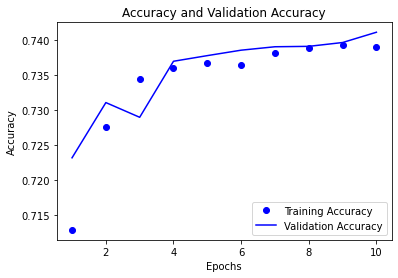

In [47]:
import matplotlib.pyplot as plt

acc= history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc) + 1)

plt.plot(epochs, acc,'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy and Validation Accuracy')
plt.show()

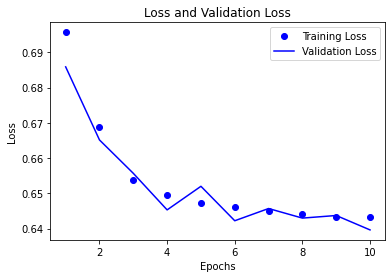

In [48]:
plt.clf()

plt.plot(epochs, loss,'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss and Validation Loss')
plt.show()

In [49]:
predictions[:,1]

array([0.9030841 , 0.9220955 , 0.6212776 , ..., 0.58548284, 0.8256252 ,
       0.7644411 ], dtype=float32)

In [50]:
predictions[:,2]

array([0.0701341 , 0.05657551, 0.12860893, ..., 0.16056976, 0.12211334,
       0.18118803], dtype=float32)

In [51]:
y_test_place[:,1]

array([1., 1., 0., ..., 1., 1., 0.], dtype=float32)

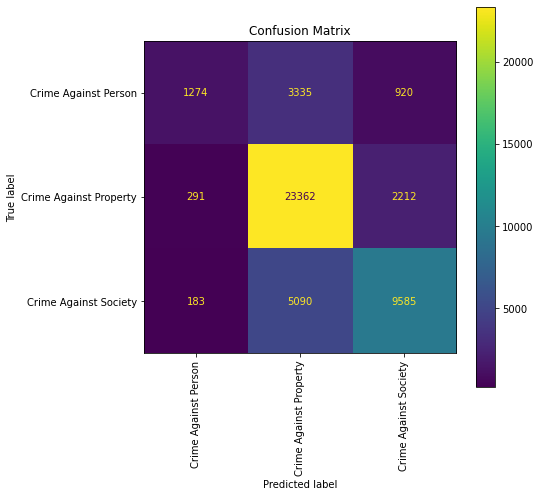

In [52]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_other, np.argmax(predictions,axis=1))

disp = ConfusionMatrixDisplay(cm, display_labels=top_classes)

disp = disp.plot()
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(7,7)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


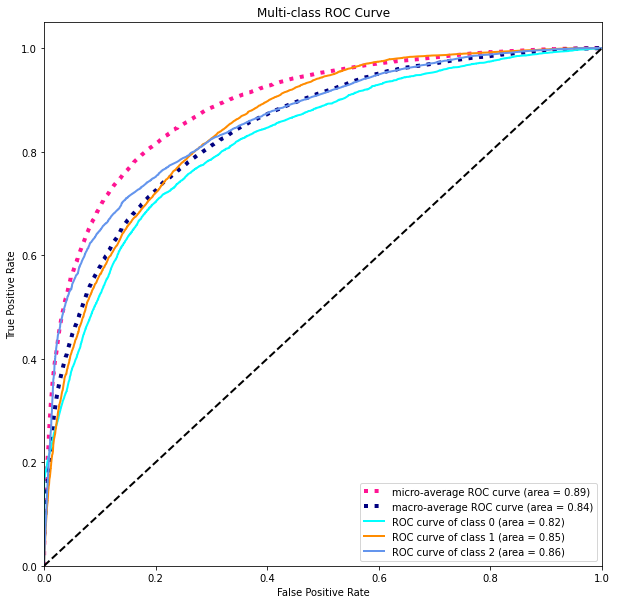

In [53]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(top_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_place[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_place.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(top_classes))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(top_classes)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(top_classes)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(top_classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()



In [54]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(top_classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_place[:, i],
                                                        predictions[:, i])
    average_precision[i] = average_precision_score(y_test_place[:, i], predictions[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_place.ravel(),
    predictions.ravel())
average_precision["micro"] = average_precision_score(y_test_place, predictions,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.82


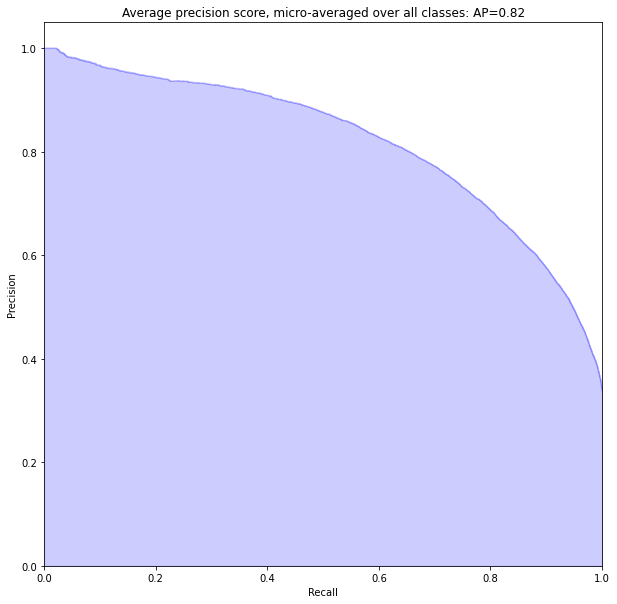

In [55]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))
fig = plt.gcf()
fig.set_size_inches(10,10)

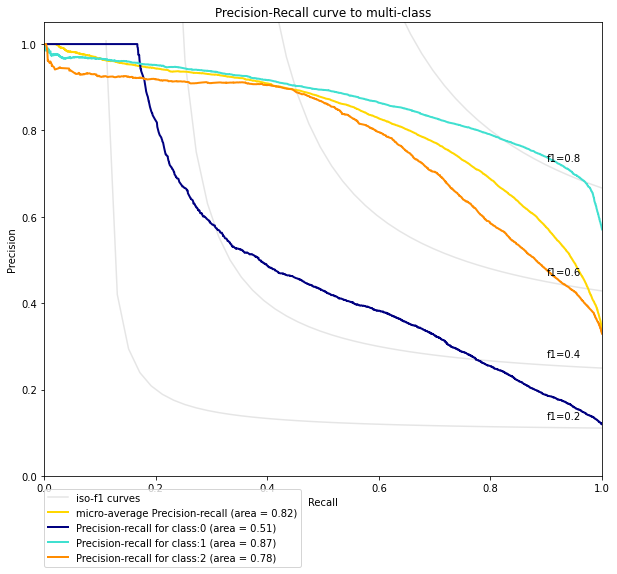

In [56]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(14, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(len(top_classes)), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.show()

In [57]:
from sklearn.metrics import roc_auc_score

macro_roc_auc_ovo = roc_auc_score(y_test_place, predictions, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test_place, predictions, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test_place, predictions, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test_place, predictions, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.844719 (macro),
0.850958 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.844719 (macro),
0.850958 (weighted by prevalence)


In [58]:
avg_acc = np.mean(acc)
avg_auc = getAvgAUC(y_test_place, predictions)
avg_precision = getAvgPrecision(top_classes, y_test_place, predictions)
avg_precision = avg_precision.get('micro')

In [59]:
results = pd.DataFrame({'General Crimes': [avg_acc, avg_precision, avg_auc]})

results.index = ['Accuracy/F1/Precision/Recall Score', 'Avg Precision Score','ROC AUC Score']

results

,General Crimes
Accuracy/F1/Precision/Recall Score,0.733955
Avg Precision Score,0.819256
ROC AUC Score,0.844719
